In [12]:
# --------------------------------------------------------------------------

# ----------------- use mcwpls

# -------------------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os


base_dir = "/home/u0106869/vfonsecad/kul_phd/teaching_assistant/multivariate_calibration"

# --- data handling modules

import numpy as np
import pandas as pd
import scipy.io as sp_io

# --- visualization modules

import matplotlib as mtply
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- my modules

methods_dir = base_dir + '/methodology/'  
sys.path.insert(0, methods_dir + '/model_building')
sys.path.insert(0, methods_dir + '/read_data')
sys.path.insert(0, methods_dir + '/preprocessing')
from class_chemometrics_data import chemometrics_data
from class_mcw_pls import mcw_pls, mcw_pls_sklearn


# ¡¡¡ --- !!! # ---> base working directory and available data cases


# ************************************ init --- user 
cases_dict = {"d0001": ["d0001_corn", "d0001_data_prepared_01"],           
             "d0023": ["d0023_milkrobot_nirsensor2017", "d0023_data_prepared_03"]}
# ************************************ end --- user 


print("--------- imports loaded ----------")




# ¡¡¡ --- !!! # ---> data


# ************************************ init --- user 
caseID_key = "d0023"
# ************************************ end --- user 

case_dir = cases_dict[caseID_key][0]
dname = cases_dict[caseID_key][1]
data_dir = '/data/' + case_dir + '/data_prepared/'





# ************************************ init --- user
data_class = chemometrics_data(base_dir + data_dir + dname + '.mat', 
                               data_identifier = data_dir + dname,
                               include_val = False,
                               include_test = True,
                               include_unlabeled = False,
                               y_all_range = False,
                               y_range = np.array([2]),
                               obs_all_cal = True,
                              shuffle = False)
# ************************************ end --- user



print(data_class.ncal, data_class.K)
print(data_class.get_test()["xtest"].shape)
print("--------- data loaded for " + data_class.data_identifier + "----------")




print("--------- functions loaded ----------")


--------- imports loaded ----------
56 700
(24, 700)
--------- data loaded for /data/d0001_corn/data_prepared/d0001_data_prepared_01!*protein *!----------
--------- functions loaded ----------


ycal mean:  [4.73708861]
ycal std:  [0.1546773]
---


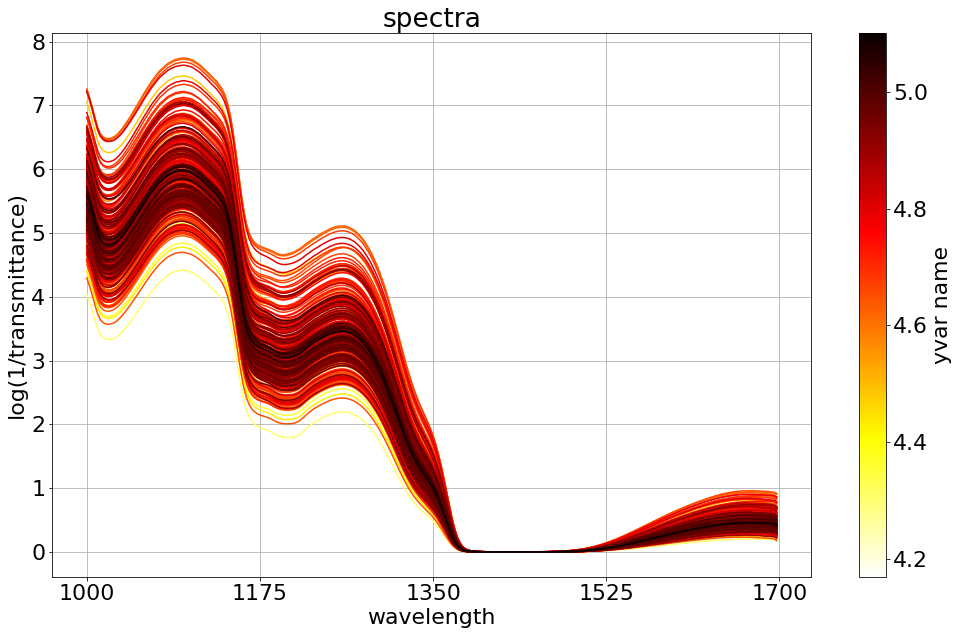

In [2]:
# ¡¡¡ --- !!! # ---> descriptive statistics and data plots


# ************************************ init --- user 

spectral_measurements_title = "log(1/transmittance)"
wavelength_min = 1000
wavelength_max = 1700
n_wavelength_ticks = 5

# ************************************ end --- user 

xcal = data_class.get_cal()["xcal"]
ycal = data_class.get_cal()["ycal"]

N,K = xcal.shape

# --- descriptive statistics 
print("ycal mean: " , ycal.mean(axis=0))
print("ycal std: " , ycal.std(axis=0))
print("---")



# --- spectral plot


plt.rcParams.update({'font.size': 22}) 
xticks_labels = np.rint(np.linspace(wavelength_min,wavelength_max,n_wavelength_ticks))
xticks_labels = xticks_labels.astype(int)


    # --- colormap 
    
c_m = mtply.cm.hot_r
norm = mtply.colors.Normalize(vmin = np.amin(ycal), vmax = np.amax(ycal))
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)
s_m.set_array([])

    # --- plot

fig, ax = plt.subplots(figsize = (17,10), facecolor="white")
for ii in np.argsort(ycal[:,0]):
    plt.plot(xcal[[ii],:].T,color=s_m.to_rgba(ycal[ii,0]))
plt.title("spectra")
plt.xlabel("wavelength")
plt.ylabel(spectral_measurements_title)
plt.xticks(np.rint(np.linspace(0,K,n_wavelength_ticks)), xticks_labels)
plt.grid()
clb = plt.colorbar(s_m)
clb.set_label("yvar name".lower())
plt.show() 


In [3]:
# ¡¡¡ --- !!! # ---> results of tuning 

tuning_results = {}
print("ready")

ready


In [4]:
# ¡¡¡ --- !!! # ---> tuning for mcw_pls



print("\n start time:---", datetime.datetime.now(), "\n")


# ************************************ init --- user 
total_lv = 20
sigma_min = 0.2
sigma_max = 4
total_sigmas = 3
kfold_splits = 10
current_R = None
maximum_iters  = 30
# ************************************ end --- user 





range_lv = np.arange(1, total_lv+1)
sigma_range = np.linspace(sigma_min, sigma_max, total_sigmas)
cv_error_matrix = np.zeros((total_lv,sigma_range.shape[0]))

xcal = data_class.get_cal()["xcal"]
ycal = data_class.get_cal()["ycal"]

ssi = 0

for sigma_i in sigma_range:
    
    for current_lv in range_lv:  
        
        # --- model object
        
        my_model = mcw_pls(xcal,ycal, current_lv)

        # --- training model

        try:
            

            my_model_trained = my_model.train(iters=30, current_R0=current_R, factor_sigma=sigma_i)
            
            # --- sample weights

            my_model_trained_sample_weights  = np.diag(my_model_trained["sample_weights"])
            my_model_trained_sample_weights.shape = (xcal.shape[0],1)

            # --- cv    

            my_model_trained_cv_pred = my_model.crossval_KFold(my_model_trained['train_object'],number_splits=kfold_splits)
            my_model_trained_cv_error = my_model.rmse(my_model_trained_cv_pred['cv_predicted'], ycal,my_model_trained_sample_weights)

            
        except np.linalg.LinAlgError:
            

            my_model_trained_cv_error = None
        


        # --- Store error 


      
        cv_error_matrix[current_lv-1,ssi] = my_model_trained_cv_error

    ssi += 1
    print(ssi)
        
    
tuning_results["mcw_pls"] = {"cv_error": cv_error_matrix,
                                "sigma_range": sigma_range
                                }




print("\n finish time:---", datetime.datetime.now())


 start time:--- 2020-07-07 12:16:30.502301 

1
2
3

 finish time:--- 2020-07-07 12:18:57.862876


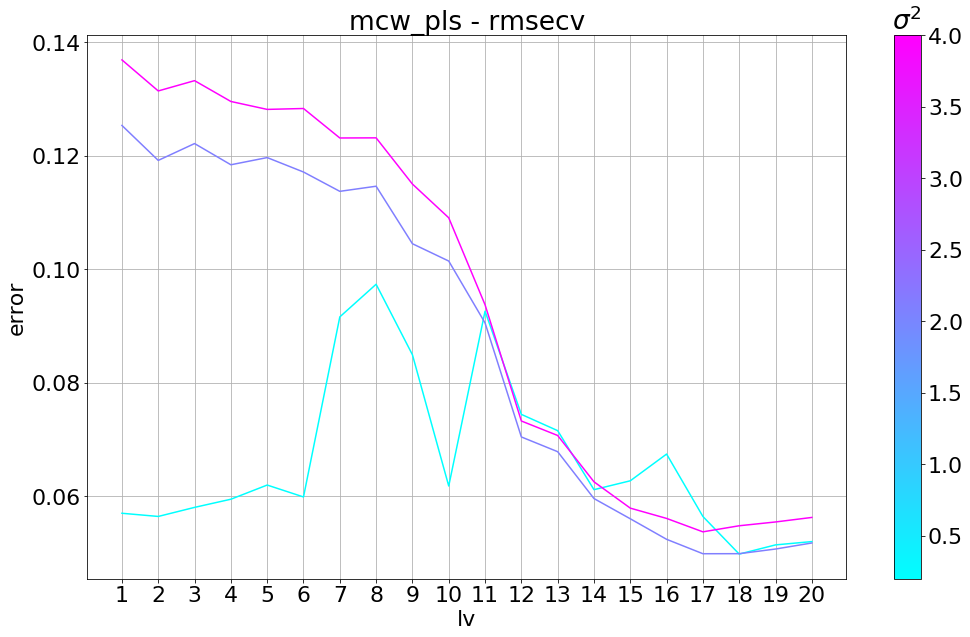

In [5]:
# ¡¡¡ --- !!! # ---> plots of cv mcw_pls


plt.rcParams.update({'font.size': 22}) 


    # --- colormap 
    
c_m = mtply.cm.cool
norm = mtply.colors.Normalize(vmin = np.amin(tuning_results["mcw_pls"]["sigma_range"]),
                              vmax = np.amax(tuning_results["mcw_pls"]["sigma_range"]))
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)
s_m.set_array([])

    # --- plot

fig, ax = plt.subplots(figsize = (17,10), facecolor="white")
for ii in range(0,tuning_results["mcw_pls"]["cv_error"].shape[1]):
    plt.plot(tuning_results["mcw_pls"]["cv_error"][:,ii],color=s_m.to_rgba(tuning_results["mcw_pls"]["sigma_range"][ii]))
plt.title("mcw_pls - rmsecv")
plt.xlabel("lv")
plt.ylabel("error")
plt.xticks(np.arange(0,tuning_results["mcw_pls"]["cv_error"].shape[0]), np.arange(1,tuning_results["mcw_pls"]["cv_error"].shape[0]+1).astype(int))
plt.grid()
clb = plt.colorbar(s_m)
clb.ax.set_title("$\sigma^2$")
plt.show() 


In [6]:
# ¡¡¡ --- !!! # ---> selected models 

selected_models = {}

print("ready")

ready


In [7]:
# ¡¡¡ --- !!! # ---> selected models mcw_pls 


# ************************************ init --- user 
selected_models["mcw_pls"] = {"model_01": {"lv": 10, "sigma2":0.5},
                                 "model_02": {"lv": 17, "sigma2":3}}
kfold_splits = 10
current_R = None
maximum_iters  = 30

# ************************************ end --- user 

xcal = data_class.get_cal()["xcal"]
ycal = data_class.get_cal()["ycal"]
xtest = data_class.get_test()["xtest"]
ytest = data_class.get_test()["ytest"]


for model_i in selected_models["mcw_pls"].keys():    
    
    print(model_i)
          
    # --- model object
    
    current_lv = selected_models["mcw_pls"][model_i]["lv"]
    
    my_model = mcw_pls(xcal,ycal, current_lv)
    
    try:

        my_model_trained = my_model.train(iters=30, current_R0=current_R, factor_sigma=sigma_i)

        # --- sample weights

        my_model_trained_sample_weights  = np.diag(my_model_trained["sample_weights"])
        my_model_trained_sample_weights.shape = (xcal.shape[0],1)

        # --- cv    

        my_model_trained_cv_pred = my_model.crossval_KFold(my_model_trained['train_object'],number_splits=kfold_splits)
        my_model_trained_cv_error = my_model.rmse(my_model_trained_cv_pred['cv_predicted'], ycal,my_model_trained_sample_weights)

        # --- test


        ytest_pred = my_model.predict(xtest,my_model_trained)
        test_error = my_model.rmse(ytest_pred, ytest)

    except np.linalg.LinAlgError:
        
        test_error = None
        my_model_trained_cv_error = None
    
    selected_models["mcw_pls"][model_i]["rmsecv"] = my_model_trained_cv_error[0]   
    selected_models["mcw_pls"][model_i]["rmsep"] = test_error[0]   
    selected_models["mcw_pls"][model_i]["trained"] = my_model_trained
    selected_models["mcw_pls"][model_i]["sample_weights"] = my_model_trained_sample_weights
    selected_models["mcw_pls"][model_i]["cv_predicted"] = my_model_trained_cv_pred['cv_predicted']
    selected_models["mcw_pls"][model_i]["test_predicted"] = ytest_pred
                                           
    
    

print("finished")

model_01
model_02
finished


In [8]:
# ¡¡¡ --- !!! # ---> selected models table


empty_line = {"algorithm": [], "model_id": [], "lv": [], "sigma2": [],  "rmsecv":[], "rmsep":[]}
selected_models_table = pd.DataFrame(data=empty_line)


for alg_i in selected_models.keys():
    
    for model_i in selected_models[alg_i].keys():
                
        new_line = {"algorithm": alg_i, "model_id" : model_i}
        
        for key_i in selected_models[alg_i][model_i].keys():
            if key_i in ["lv", "sigma2", "rmsecv",  "rmsep"]:
                new_line.update({key_i:selected_models[alg_i][model_i][key_i]})

        selected_models_table = selected_models_table.append(new_line,ignore_index=True)

selected_models_table

,algorithm,model_id,lv,sigma2,rmsecv,rmsep
0,mcw_pls,model_01,10.0,0.5,0.109057,0.119209
1,mcw_pls,model_02,17.0,3.0,0.053763,0.082819


In [9]:
# --- the dictionary selected_models contains all other output to explore the model
print(selected_models.keys())
print(selected_models["mcw_pls"].keys())
print(selected_models["mcw_pls"]["model_01"].keys())
print(selected_models["mcw_pls"]["model_01"]["trained"].keys()) # --- see help(my_model.train) for further information


dict_keys(['mcw_pls'])
dict_keys(['model_01', 'model_02'])
dict_keys(['lv', 'sigma2', 'rmsecv', 'rmsep', 'trained', 'sample_weights', 'cv_predicted', 'test_predicted'])
dict_keys(['BPLS', 'x_mean', 'y_mean', 'x_scores', 'x_weights', 'x_scores_coef', 'fitted', 'train_object', 'sample_weights', 'factor_sigma'])


In [10]:
help(my_model.train)

Help on method train in module class_mcw_pls:

train(iters=30, current_R0=None, factor_sigma=1) method of class_mcw_pls.mcw_pls instance
    'BPLS': regression vector
    'x_mean': mean of x
                     'y_mean':mean of y
                     'x_scores': T scores
                     'x_weights': x loadings
                     'x_scores_coef' : coefficients of regression between T scores and Y
                     'fitted': fitted y values
                     'train_object': sklearn train object,
                     'sample_weights': sample weights,
                     'factor_sigma': sigma factor

